In [456]:

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fsolve

LAMBDA = 1.73e-9 # Decay constant for tritium
N_burn = 9.3e-7 # Tritium burn rate in the plasma
TBR = 1.1

class Component:
    def __init__(self, name, residence_time, initial_inventory=0, tritium_source=0):
        self.name = name
        self.residence_time = residence_time
        self.input_ports = {}  # Dictionary where the key is the port name and the value is the port object
        self.output_ports = {}  # Dictionary where the key is the port name and the value is the port object
        self.tritium_inventory = initial_inventory
        self.tritium_source = tritium_source
        # self.equation = 0

    def add_input_port(self, port_name, incoming_fraction=1.0):
        if not (0 <= incoming_fraction <= 1):
            raise ValueError("Incoming fraction must be between 0 and 1")
        port = Port(port_name)
        port.incoming_fraction = incoming_fraction
        self.input_ports[port_name] = port
        return port

    def add_output_port(self, port_name):
        port = Port(port_name)
        self.output_ports[port_name] = port
        return port

    def __str__(self):
        return f"{self.name}: Residence Time = {self.residence_time}, Tritium Inventory = {self.tritium_inventory}"

    def add_tritium(self, amount):
        self.tritium_inventory += amount

    def remove_tritium(self, amount):
        if self.tritium_inventory >= amount:
            self.tritium_inventory -= amount
            return amount
        else:
            removed_amount = self.tritium_inventory
            self.tritium_inventory = 0
            return removed_amount
        
    def get_inflow(self):
        inflow = 0
        for port in self.input_ports.values():
            inflow += port.flow_rate
        return inflow   
        
    def get_outflow(self):
        return self.tritium_inventory / self.residence_time
    
    def calculate_inventory_derivative(self):
        inflow = self.get_inflow()
        outflow = self.get_outflow()
        decay = self.tritium_inventory * LAMBDA  # assuming decay_rate is a constant
        dydt = inflow - outflow - decay + self.tritium_source
        return dydt
    
    def update_inventory(self, new_value):
        self.tritium_inventory = new_value
    
class Plasma(Component):
    def __init__(self, name, N_burn, TBE, **kwargs):
        super().__init__(name, residence_time=1, **kwargs)
        self.N_burn = N_burn
        self.TBE = TBE

    # From fueling system
    def get_inflow(self):
        return self.N_burn / self.TBE

    # Exhaust
    def get_outflow(self):
        return (1 - self.TBE)/self.TBE * self.N_burn
    
    def calculate_inventory_derivative(self):
        return super().calculate_inventory_derivative() - self.N_burn


class FuelingSystem(Component):
    def __init__(self, name, N_burn, TBE, **kwargs):
        super().__init__(name, residence_time=1, **kwargs)
        self.N_burn = N_burn
        self.TBE = TBE

    # To plasma
    def get_outflow(self):
        return self.N_burn/self.TBE

class Port:
    def __init__(self, name, incoming_fraction=1.0):
        self.name = name
        self.flow_rate = 0
        self.incoming_fraction = incoming_fraction
        
    def set_flow_rate(self, flow_rate):
        self.flow_rate = flow_rate
    
class ComponentMap:
    def __init__(self):
        self.components = {}
        self.connections = {}

    def add_component(self, component):
        self.components[component.name] = component

    def connect_ports(self, component1, port1, component2, port2):
        if component1.name not in self.connections:
            self.connections[component1.name] = {}
        if component2.name not in self.connections:
            self.connections[component2.name] = {}

        self.connections[component1.name][port1.name] = (component2.name, port2.name)
        self.connections[component2.name][port2.name] = (component1.name, port1.name)
        if port1 and port2:
                port1.set_flow_rate(component1.get_outflow())
                port2.set_flow_rate(component1.get_outflow() * port2.incoming_fraction)

    def disconnect_ports(self, component1, port1, component2, port2):
        if component1.name in self.connections and port1.name in self.connections[component1.name]:
            del self.connections[component1.name][port1.name]
        if component2.name in self.connections and port2.name in self.connections[component2.name]:
            del self.connections[component2.name][port2.name]

    def get_connected_ports(self, component, port):
        if component.name in self.connections and port.name in self.connections[component.name]:
            connected_component_name, connected_port_name = self.connections[component.name][port.name]
            connected_component = self.components[connected_component_name]
            connected_port = connected_component.input_ports[connected_port_name]
            return connected_component, connected_port
        else:
            return None, None
        
    def update_flow_rates(self):
        for component_name, ports in self.connections.items():
            for port_name, (connected_component_name, connected_port_name) in ports.items():
                if port_name in self.components[component_name].output_ports:
                    component = self.components[component_name]
                    port = component.output_ports[port_name]
                    connected_component = self.components[connected_component_name]
                    connected_port = connected_component.input_ports[connected_port_name]
                    port.set_flow_rate(component.get_outflow())
                    connected_port.set_flow_rate(component.get_outflow() * connected_port.incoming_fraction)

    def print_connected_map(self):
        for component_name, ports in self.connections.items():
            print(f"Component: {component_name}")
            for port_name, (connected_component_name, connected_port_name) in ports.items():
                print(f"  Port: {port_name} -> Connected Component: {connected_component_name}, Connected Port: {connected_port_name}")

class Simulate:
    def __init__(self, dt, final_time, component_map):
        self.dt = dt
        self.final_time = final_time
        self.time = []
        self.n_steps = int(final_time / dt)
        self.initial_conditions = {name: component.tritium_inventory for name, component in component_map.components.items()}
        self.I_startup = component_map.components['Fueling System'].tritium_inventory
        self.y = np.zeros((self.n_steps + 1, len(self.initial_conditions)))
        self.components = component_map.components
        self.component_map = component_map

    def run(self):
        while True:
            self.y[0] = [component.tritium_inventory for component in self.components.values()] # self.initial_conditions, possibly updated by the restart method
            t,y = self.forward_euler()
            if self.components['Fueling System'].tritium_inventory < 0:
                print("Error: Tritium inventory in Fueling System is below zero.")
                self.update_I_startup()
                self.restart()
            else:
                return t,y
            
    def update_I_startup(self):
        self.I_startup += 0.1
        self.initial_conditions['Fueling System'] = self.I_startup

    def restart(self):
        self.time = []
        self.y = np.zeros((self.n_steps + 1, len(self.initial_conditions)))
        for component, initial_condition in zip(self.components.values(), self.initial_conditions.values()):
            component.tritium_inventory = initial_condition

    def forward_euler(self):
        print(self.y[0])
        for n in range(self.n_steps):
            t = n * self.dt
            if n % 1000 == 0:
                print(f"Percentage completed = {n/self.n_steps * 100:.1f}%", end='\r')
            dydt = self.f(self.y[n])
            self.y[n+1] = self.y[n] + self.dt * dydt
            self.time.append(t)
            for i, component in enumerate(self.components.values()):
                component.update_inventory(self.y[n+1][i])
            self.component_map.update_flow_rates()
        return [self.time, self.y[:-1,:]]

    # def forward_euler(self):
    #     self.y[0] = self.initial_conditions
    #     for n in range(self.n_steps):
    #         t = n * self.dt
    #         if n % 1000 == 0:
    #             fueling_system = self.components['Fueling System']
    #             if fueling_system.tritium_inventory < 0:
    #                 print("Error: Tritium inventory in Fueling System is below zero.")
    #                 fueling_system.tritium_inventory += 0.1
    #                 self.forward_euler()  # Run the simulation again
    #                 return  # Stop the current iteration of the loop
    #     dydt = self.f(self.y[n])
    #     self.y[n+1] = self.y[n] + self.dt * dydt
    #     self.time.append(t)
    #     for i, component in enumerate(self.components.values()):
    #         component.update_inventory(self.y[n+1][i])
    #     self.component_map.update_flow_rates()
    #     return [self.time, self.y[:-1,:]]
    
    def f(self, y):
        dydt = np.zeros_like(y)
        for i, component in enumerate(self.components.values()):
            dydt[i] += component.calculate_inventory_derivative()
        return dydt 
    
    

In [457]:
def visualize_connections(component_map):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes for each component
    for component in component_map.components.values():
        G.add_node(component.name)

    # Add edges for each connection
    for component_name, ports in component_map.connections.items():
        for port_name, (connected_component_name, _) in ports.items():
            if port_name in component_map.components[component_name].output_ports:
                G.add_edge(component_name, connected_component_name)

    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, edge_color='gray', arrows=True)

    # Show the plot
    plt.show()


In [458]:
tau_ofc = 2 * 3600
tau_ifc = 4 * 3600
I_startup = 0.5 
TBE = 0.02
component1 = FuelingSystem("Fueling System", N_burn, TBE, initial_inventory=I_startup)
component2 = Component("OFC", tau_ofc, initial_inventory=0, tritium_source=N_burn * TBR)
component3 = Component("IFC", tau_ifc)
component4 = Plasma("Plasma", N_burn, TBE)
port1 = component1.add_output_port("Port 1")
port2 = component4.add_input_port("Port 2")
port3 = component4.add_output_port("Port 3")
port4 = component3.add_input_port("Port 4")
port5 = component3.add_output_port("Port 5")
port6 = component2.add_output_port("Port 6")
port7 = component1.add_input_port("Port 7")
port8 = component3.add_input_port("Port 8")

component_map = ComponentMap()
component_map.add_component(component1)
component_map.add_component(component2)
component_map.add_component(component3)
component_map.add_component(component4)
component_map.connect_ports(component1, port1, component4, port2)
component_map.connect_ports(component4, port3, component3, port4)
component_map.connect_ports(component3, port5, component1, port7)
component_map.connect_ports(component2, port6, component3, port8)
component_map.print_connected_map()
# visualize_connections(component_map)
component1.get_inflow()

Component: Fueling System
  Port: Port 1 -> Connected Component: Plasma, Connected Port: Port 2
  Port: Port 7 -> Connected Component: IFC, Connected Port: Port 5
Component: Plasma
  Port: Port 2 -> Connected Component: Fueling System, Connected Port: Port 1
  Port: Port 3 -> Connected Component: IFC, Connected Port: Port 4
Component: IFC
  Port: Port 4 -> Connected Component: Plasma, Connected Port: Port 3
  Port: Port 5 -> Connected Component: Fueling System, Connected Port: Port 7
  Port: Port 8 -> Connected Component: OFC, Connected Port: Port 6
Component: OFC
  Port: Port 6 -> Connected Component: IFC, Connected Port: Port 8


0.0

[0.5 0.  0.  0. ]
Error: Tritium inventory in Fueling System is below zero.
[0.6 0.  0.  0. ]
Error: Tritium inventory in Fueling System is below zero.
[0.7 0.  0.  0. ]
[ 3.15558627e-02  7.36550141e-03  6.70261489e-01 -4.23516050e-17]


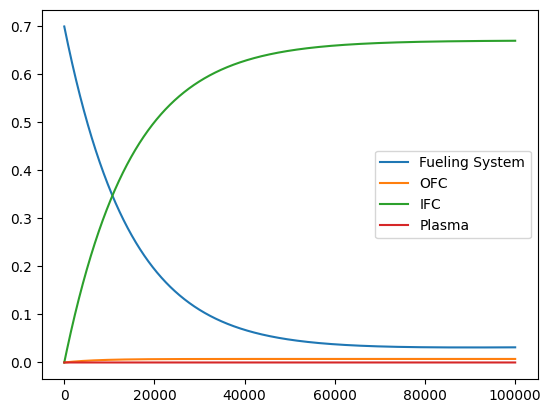

In [459]:
simulation = Simulate(0.1, 1e5, component_map)
t, y = simulation.run()
plt.plot(t, y)
plt.legend(component_map.components.keys())
print(y[-1,:])